In [1]:
%cd ../../
import pandas as pd
import os
import json
from orderbookrl.evaluate.hp_utils import get_data, get_dataframe
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
from sklearn import tree
import graphviz 
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

logs_dir = 'logs/marketorderenv/hpsearch-ppoadv/'
cols = ['episode_reward_max', 'episode_reward_min',  'episode_reward_mean',
       'timesteps_this_iter']
data_dict = get_data(logs_dir, cols)

hpcols = set(['lambda', 'gamma'])
temp = get_dataframe(data_dict, hpcols)

/home/olle/PycharmProjects/orderbookrl


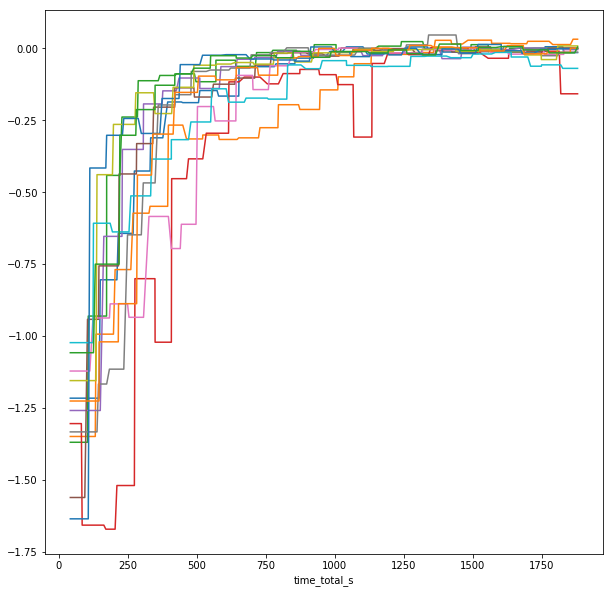

In [2]:
temp = temp.ffill().bfill()
temp.rolling(1).mean().dropna().plot(figsize=(10,10), legend=False); # .legend(bbox_to_anchor=(1.1, 1));

In [3]:
x = temp[700:].mean()
x.sort_values(ascending=False).head(n=30).to_frame()

0
gamma lambda          
0.9   0.8    -0.001413
      0.9    -0.005466
0.99  0.99   -0.010968
0.9   0.6    -0.013048
0.99  0.8    -0.013203
0.9   0.4    -0.014378
0.999 0.99   -0.014890
0.99  0.9    -0.016129
0.9   0.99   -0.016447
0.999 0.8    -0.019858
0.99  0.4    -0.060189
0.999 0.9    -0.063960
0.99  0.6    -0.069282

In [4]:
x.sort_values(ascending=False).tail(n=30).to_frame()

0
gamma lambda          
0.9   0.8    -0.001413
      0.9    -0.005466
0.99  0.99   -0.010968
0.9   0.6    -0.013048
0.99  0.8    -0.013203
0.9   0.4    -0.014378
0.999 0.99   -0.014890
0.99  0.9    -0.016129
0.9   0.99   -0.016447
0.999 0.8    -0.019858
0.99  0.4    -0.060189
0.999 0.9    -0.063960
0.99  0.6    -0.069282

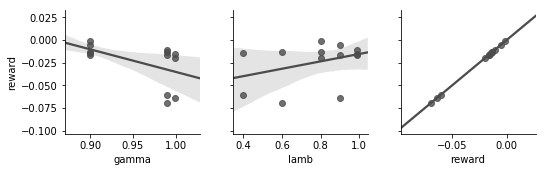

In [5]:
data = x.to_frame(name='reward').reset_index().astype(float)
data = data.rename(columns={'lambda':'lamb'})
cols = [str(c) for c in data.columns]

g = sns.PairGrid(data, x_vars=cols, y_vars='reward')
g.map(sns.regplot, color=".3");

In [6]:
' + '.join(cols)

'gamma + lamb + reward'

In [7]:
data_mean = data.subtract(data.mean()) / data.std()
model = ols(formula='reward ~ ' + '  + '.join(cols),
             data=data_mean).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 reward   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 4.718e+30
Date:                Mon, 27 Aug 2018   Prob (F-statistic):          3.37e-136
Time:                        20:59:57   Log-Likelihood:                 434.02
No. Observations:                  13   AIC:                            -860.0
Df Residuals:                       9   BIC:                            -857.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.776e-16   2.55e-16     -1.087      0.305   -8.55e-16       3e-16
gamma       1.249e-16   3.43e-16      0.365      0.724    -6.5e-16       9e-16
lamb        6.557e-16   3.18e-16      2.063      0.069   -6.32e-17    1.37e-15
reward         1.0000   3.63e-16   2.75e+15      0.000       1.000       1.000
==============================================================================
Omnibus:                        1.936   Durbin-Watson:                   1.191
Prob(Omnibus):                  0.380   Jarque-Bera (JB):                1.452
Skew:                           0.703   Prob(JB):                        0.484
Kurtosis:                       2.162   Cond. No.                         2.32
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

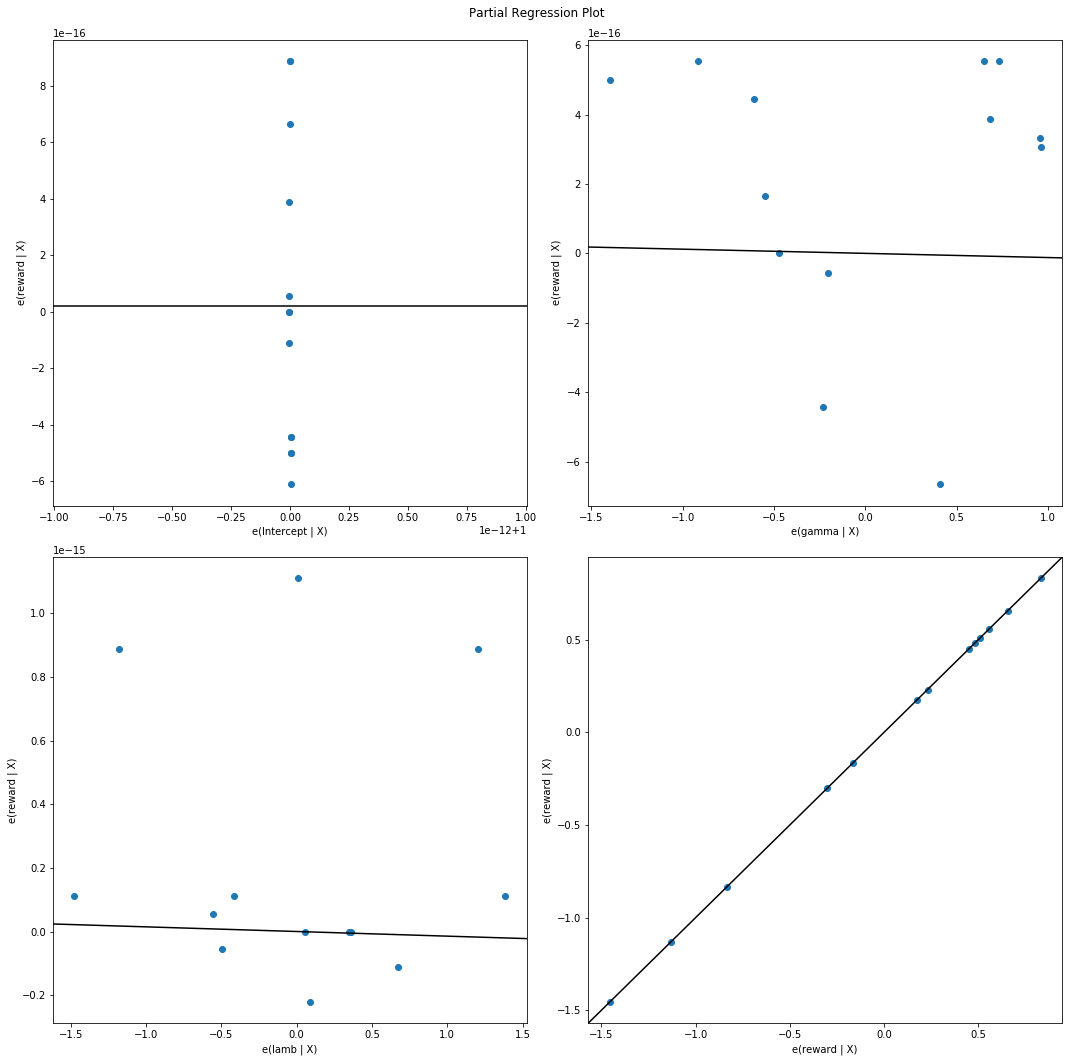

In [8]:
fig = plt.figure(figsize=(15,15))
sm.graphics.plot_partregress_grid(model, fig=fig);

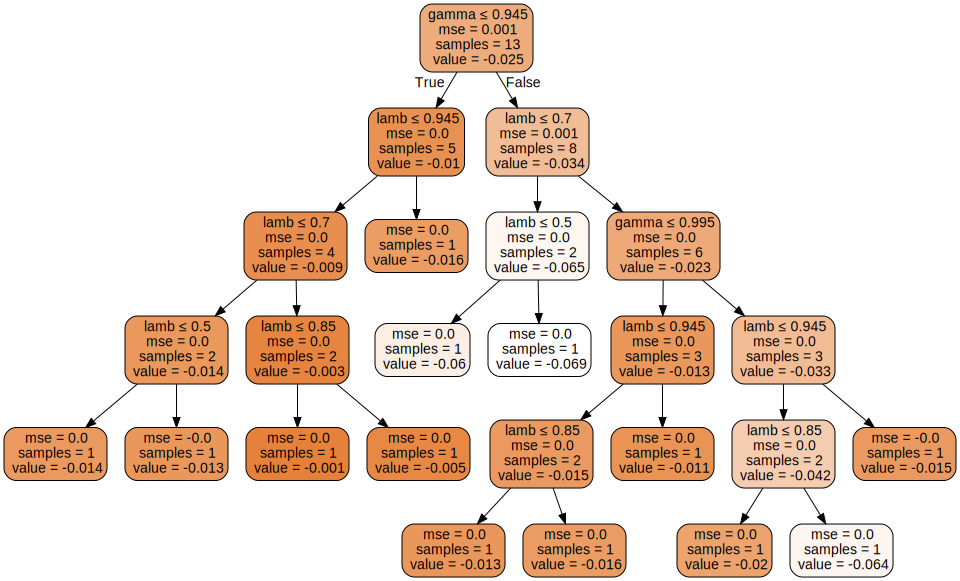

In [9]:
cols = ['gamma', 'lamb']
reg = tree.DecisionTreeRegressor().fit(data[cols], data['reward'])
dot_data = tree.export_graphviz(reg, out_file=None,
                         feature_names=cols,   
                         filled=True, rounded=True,  
                         special_characters=True)  
graphviz.Source(dot_data)  